In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [2]:
# VARIABLES
CSV_FILE = 'dataset/packet_features_data.csv'

In [3]:
# 1. Load data
df = pd.read_csv(CSV_FILE)
features = ['packetId','length','direction','iat','entropy']
X = df[features].copy()
X['direction'] = X['direction'].map({'INCOMING': 0, 'OUTGOING': 1})
y = df['label']

le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
y_enc = to_categorical(y_int, num_classes)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
X3 = X_scaled  # no time-series reshape yet

In [4]:
# 2. Build SAE encoder
input_dim = X3.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu', name='bottleneck')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X3, X3, epochs=20, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 9s 731us/step - loss: 0.0440 - val_loss: 0.0015
Epoch 2/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 8s 652us/step - loss: 7.5613e-04 - val_loss: 2.6425e-04
Epoch 3/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 9s 731us/step - loss: 0.0018 - val_loss: 1.9463e-04
Epoch 4/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0021 - val_loss: 9.1479e-05
Epoch 5/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 1.8489e-04 - val_loss: 8.2620e-05
Epoch 6/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 10s 861us/step - loss: 1.7604e-04 - val_loss: 2.6123e-04
Epoch 7/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 6s 517us/step - loss: 1.8361e-04 - val_loss: 1.4418e-04
Epoch 8/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 7s 571us/step - loss: 5.2691e-04 - val_loss: 2.5237e-04
Epoch 9/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 6s 509us/step - loss: 2.0315e-04 - val_loss: 8.4900e-04
Epoch 10/20
12082/12082 ━━━━━━━━━━━━━━━━━━━━ 6s 485us/step - loss: 5.3813e-04 - val_loss: 0.0012
Epoch 11/20
12082/12

In [5]:
# 3. Encode features
X_encoded = encoder.predict(X3)  # shape (n_samples, 8)

53694/53694 ━━━━━━━━━━━━━━━━━━━━ 20s 373us/step


In [6]:
# 4. Prepare CNN training data
X_cnn = X_encoded.reshape((X_encoded.shape[0], X_encoded.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_enc, test_size=0.2, stratify=y_int, random_state=42
)

In [7]:
# 5. Build 1D‑CNN classifier
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_cnn.shape[1],1)),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# 6. Train CNN
history = model.fit(X_train, y_train, validation_split=0.1,
                    epochs=20, batch_size=64, verbose=1)

Epoch 1/20
19330/19330 ━━━━━━━━━━━━━━━━━━━━ 17s 874us/step - accuracy: 0.6452 - loss: 0.6594 - val_accuracy: 0.6766 - val_loss: 0.5948
Epoch 2/20
19330/19330 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.6682 - loss: 0.6065 - val_accuracy: 0.6880 - val_loss: 0.5855
Epoch 3/20
19330/19330 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.6719 - loss: 0.6029 - val_accuracy: 0.6865 - val_loss: 0.5840
Epoch 4/20
19330/19330 ━━━━━━━━━━━━━━━━━━━━ 17s 883us/step - accuracy: 0.6722 - loss: 0.6004 - val_accuracy: 0.6865 - val_loss: 0.5819
Epoch 5/20
19330/19330 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.6729 - loss: 0.5969 - val_accuracy: 0.6832 - val_loss: 0.5791
Epoch 6/20
19330/19330 ━━━━━━━━━━━━━━━━━━━━ 18s 942us/step - accuracy: 0.6753 - loss: 0.5922 - val_accuracy: 0.6872 - val_loss: 0.5784
Epoch 7/20
19330/19330 ━━━━━━━━━━━━━━━━━━━━ 19s 969us/step - accuracy: 0.6748 - loss: 0.5907 - val_accuracy: 0.6885 - val_loss: 0.5768
Epoch 8/20
19330/19330 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - ac

In [9]:
# 7. Save models and preprocessing
autoencoder.save("autoencoder.keras")
model.save("sae_cnn_model.keras")
joblib.dump(scaler, "scaler_sae.save")
joblib.dump(le, "label_encoder_sae.joblib")

['label_encoder_sae.joblib']

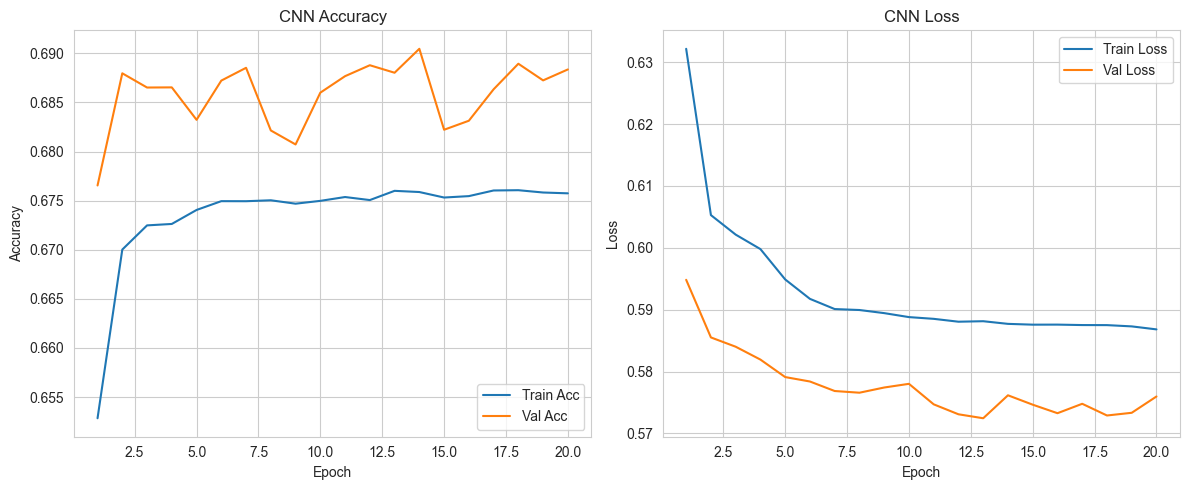

In [10]:
# 8. Plot training curves
epochs = range(1, len(history.history['accuracy'])+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history.history['accuracy'], label='Train Acc')
plt.plot(epochs, history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'), plt.ylabel('Accuracy'), plt.legend(), plt.title('CNN Accuracy')
plt.subplot(1,2,2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend(), plt.title('CNN Loss')
plt.tight_layout()
plt.show()

10739/10739 ━━━━━━━━━━━━━━━━━━━━ 2s 214us/step


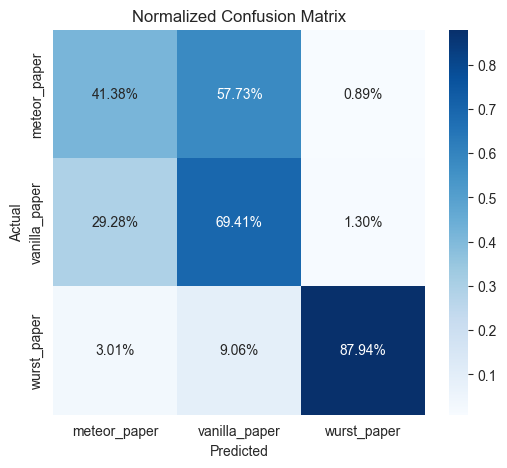

Classification report:
               precision    recall  f1-score   support

 meteor_paper       0.55      0.41      0.47    100750
vanilla_paper       0.50      0.69      0.58    101998
  wurst_paper       0.98      0.88      0.93    140890

     accuracy                           0.69    343638
    macro avg       0.68      0.66      0.66    343638
 weighted avg       0.71      0.69      0.69    343638



In [11]:
# 9. Evaluate test set
y_pred_prob = model.predict(X_test)
y_pred_int = np.argmax(y_pred_prob, axis=1)
y_test_int = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_int, y_pred_int)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2%",
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel('Predicted'), plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

print("Classification report:")
print(classification_report(y_test_int, y_pred_int, target_names=le.classes_))